For the XGBoost we will test on tf-idf, both with and without balanced class, check on styling features, and all combined together.

Feature setups:

    TF-IDF only

    TF-IDF + balancing (ROS)

    TF-IDF + balancing + stylistic features

For balance, use ROS, as it works good on modertae imbalance. Test set will remain untouched.

In [23]:
from src.utils import load_cleaned_data, split, metrics, plot_confusion_matrix, store_metrics
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
import csv


Setup for storing metrics

In [24]:
results = []

# TF-IDF ONLY

In [25]:
#Set up dataset
df = load_cleaned_data("data/byarticle_clean.tsv")

print("\n=== XGBoost + TF-IDF ===")
X,y = df['full_text'], df['label']

X_train_text, X_test_text, y_train, y_test = split(X,y)


=== XGBoost + TF-IDF ===


In [26]:
#TF-IDF set up
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)


In [27]:
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)
y_proba = model.predict_proba(X_test_vec)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Display

Accuracy: 0.80
Balanced Accuracy: 0.76
Precision: 0.79
Recall: 0.62
F1: 0.70
AUC: 0.86


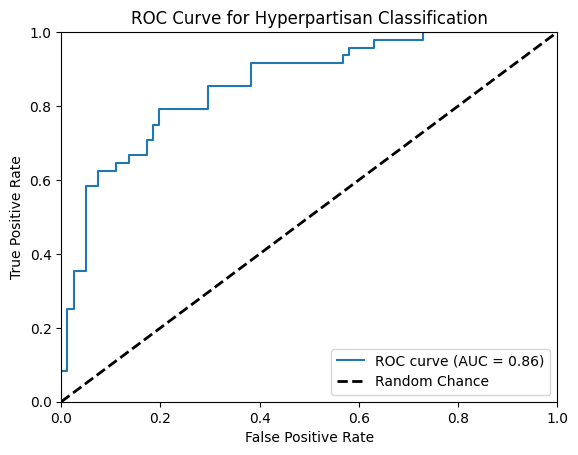

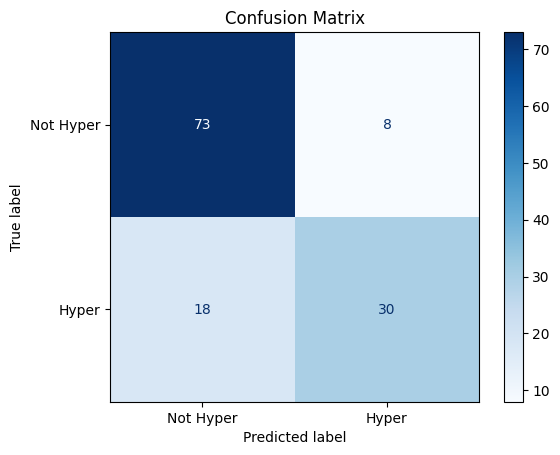

In [28]:
metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)

store_metrics(results, "XGBoost", "TF-IDF", y_test, y_pred, y_proba)


#TF-IDF + ROS

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:07:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.79
Balanced Accuracy: 0.77
Precision: 0.74
Recall: 0.67
F1: 0.70
AUC: 0.85


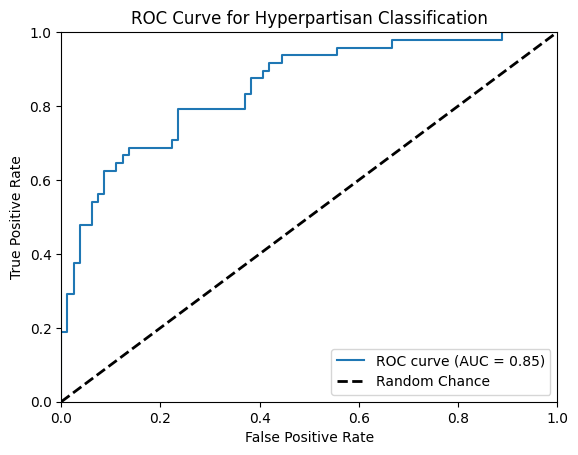

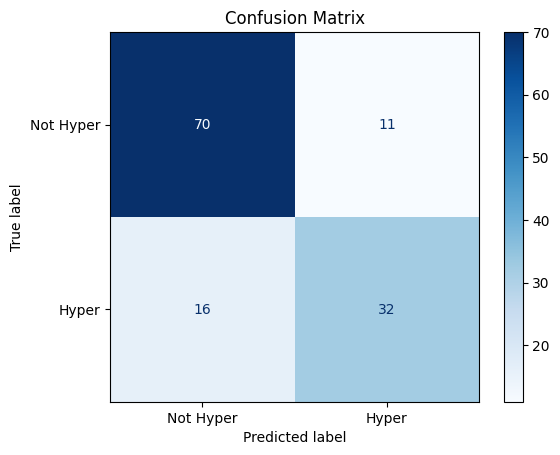

In [29]:
ros = RandomOverSampler(random_state=0)

X_train_res, y_train_res = ros.fit_resample(X_train_vec, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_vec)
y_proba = model.predict_proba(X_test_vec)[:, 1]

metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)

store_metrics(results, "XGBoost", "TF-IDF + ROS", y_test, y_pred, y_proba)


#TF-IDF + ROS + Style

In [30]:
style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']
X_text_vec = vectorizer.fit_transform(df['full_text'])
X_style = df[style_features].values
X_combined = hstack([X_text_vec, X_style])

X_train, X_test, y_train, y_test = split(X_combined, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.79
Balanced Accuracy: 0.77
Precision: 0.72
Recall: 0.71
F1: 0.72
AUC: 0.83


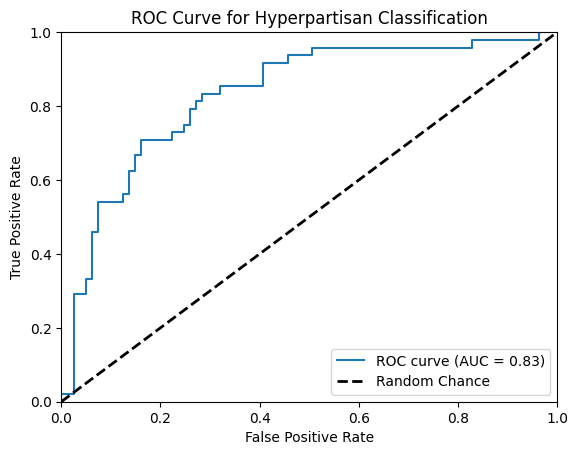

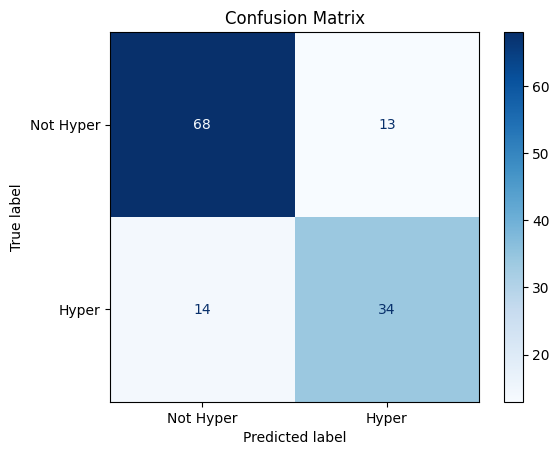

In [31]:
ros = RandomOverSampler(random_state=0)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)

store_metrics(results, "XGBoost", "TF-IDF + Style + ROS", y_test, y_pred, y_proba)


# Final table


In [32]:
# Save all results to CSV
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Table ===")
print(results_df.to_string(index=False))


=== Model Comparison Table ===
  Model                Setup  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score   AUC
XGBoost               TF-IDF     0.798              0.763      0.789   0.625     0.698 0.858
XGBoost         TF-IDF + ROS     0.791              0.765      0.744   0.667     0.703 0.848
XGBoost TF-IDF + Style + ROS     0.791              0.774      0.723   0.708     0.716 0.832


# Analyze


TF-IDF only:	Very sharp, conservative model. High precision (detects true hyperpartisan articles well), but lower recall.

+ ROS:  Helps XGBoost catch more hyperpartisan articles. Precision drops slightly (expected).


+ Style: Boosts general balance and makes predictions less skewed.


Why TF-IDF + Style + ROS is better overall:

    Best F1 Score (0.716) → balances precision and recall best

    Best Recall (0.708) → better at catching hyperpartisan articles

    Best Balanced Accuracy → handles imbalance better

    Still strong AUC (0.832) → not far behind

In [34]:
result = [row for row in results if row["Setup"] == "TF-IDF + Style + ROS"]
df_single = pd.DataFrame(result)
df_single.to_csv("results/byarticleBaseline_results.csv", mode='a', index=False, header=False)